 <center> <h1> PROJET ELTDM </h1> </center>
<FONT size="4pt"> <br> <b>Sujet :</b> Implémentation de l'algorithme KMeans

 </b>
<br> <b>Base de données : </b> Spots TV de la BBC
<br> <b>Elève </b>: Eva HOYAU & Claudia DELGADO</FONT>


<FONT size="3pt"> <br> <b>Plan du Projet : </b>
<ul>
<b> I - Introduction </b> 
<br> <b> II - Travaux préliminaires </b> 
     <ul>
     <FONT size="2pt">
     <li type="none"> <b> II - 1. </b> Chargement des données   
     </li>
     <li type="none"> <b> II - 2. </b> Traitement des données
     </li>
     <li type="none"> <b> II - 3. </b> Partitionnement des données en base d'apprentissage et base test
     </li>
     </FONT>
    </ul>
<b> III - Implémentation de l'algorithme Kmeans </b> 
     <ul>
     <FONT size="2pt">
     <li type="none"> <b> II - 1. </b> Sklearn
     </li>
     <li type="none"> <b> III - 2. </b> Distribué
     <ul> <ul>
                    <FONT size="2pt">
                    <li type="none"> Définitions des différentes fonctions utilisées 
                    </li>
                    </FONT>
                     <li type="none"> Performances de l'algorithme
                    </li>
                    </ul> </ul>
     
     </li>
    </FONT>
     </ul>

     <b> IV - Conclusion </b> 

</ul>
</FONT>


In [1]:
from __future__ import print_function
from sklearn.cluster import KMeans 
#import findspark
#findspark.init()
#import spark
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.clustering import BisectingKMeans
from pyspark import SparkContext
from pyspark import SparkConf
import pandas as pd 
import numpy as np 
from numpy import array 
from collections import Counter
import random 
from pyspark.sql import Row
from sklearn.metrics.cluster import homogeneity_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans 
from sklearn.model_selection import train_test_split
from sklearn.cluster import k_means
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt

#sc=SparkContext()

In [ ]:
#%pylab

# I - Introduction

# II - Travaux préliminaires

### II - 1 Chargement des données

In [2]:
data = sc.textFile("BBC.txt")

### II - 2 Traitement des données

In [3]:
# Les données se trouvant dans notre fichier.text étant séparées par des espaces
# on utlise la fonction line.split(' ') pour les séparer
parsedData = data.map(lambda line : 
                      [str(x).split(':') for x in line.split(' ')[1:]])

# Les labels des 17720 observations
labels = data.map(lambda lines :
                  [str(l) for l in lines.split(' ')[:1]])

# les index des colonnes remplies pour chaque observation
index=parsedData.map(lambda lines :
                  [l[0] for l in lines])
liste_index=[item for sublist in index.collect() for item in sublist]

# On compte l'occurrence de chaque index rempli 
count = Counter(liste_index)

# On garde les index qui sont compris dans chaque observation : il y en a 19
keep_index = [ str(i) for i in sorted([int(i) for i in [num[0] for num in count.most_common(19)]])]

# Les données relatives au 17720 observations qui serviront pour l'implémentation des différents algorithmes
# METHODE 2 : keep_data_meth2=[i[1] for sublist in parsedData.collect() for i in sublist if i[0] in keep_index]
keep_data=parsedData.map(lambda lines :
                  np.array([float(sublist[1]) for sublist in lines if sublist[0] in keep_index]))


### II - 3 Partitionnement des données en base d'apprentissage et base test

In [4]:
def partionnement(data,p=0.10,h=2,labels=None):
    # h : nombre de partitions dans notre calcul distribué
    # p : pourcentage de la base test
    # N : Nombre de ligne dans notre base
    N=len(keep_data.collect())
    q=1-p

    if type(h)!= int:
        print("h étant un nombre de partition, il doit être entier")
        sys.exit()
    
    if labels != None :
        N_bis=len(labels.collect())
        if N != N_bis :
            print("La base data et la base labels doivent avoir la même taille")
            sys.exit()
    
    # Afin de générer la même base test/app d'un ordinateur à un autre on rajout un .seed()
    random.seed(10)
    liste_aleatoire = [i for subset in [['T']*int(N*p),['A']*int(N*q)] for i in subset]
    random.shuffle(liste_aleatoire) 
    x = sc.parallelize(liste_aleatoire,h) 
    y = sc.parallelize(keep_data.collect(),h)
    data_al = x.zip(y)
    data_app = data_al.map(lambda lines:
                              [l for l in lines[1] if lines[0]=='A']).filter(lambda x: x != [])
    data_app = data_app.map(lambda lines:
                             array([l for l in lines]))
    data_test = data_al.map(lambda lines:
                              [l for l in lines[1] if lines[0]=='T']).filter(lambda x: x != [])
    data_test = data_test.map(lambda lines:
                             array([l for l in lines]))
    mon_dictionnaire = {}
    mon_dictionnaire["data_app"] = data_app
    mon_dictionnaire["data_test"] = data_test
    
    if labels != None :
        z = sc.parallelize(labels.collect(),h)
        labels_al =x.zip(z)
        labels_app = labels_al.map(lambda lines:
                              [l for l in lines[1] if lines[0]=='A']).filter(lambda x: x != [])
        labels_app = labels_app.map(lambda lines:
                             array([l for l in lines]))
        labels_test = labels_al.map(lambda lines:
                              [l for l in lines[1] if lines[0]=='T']).filter(lambda x: x != [])
        labels_test = labels_test.map(lambda lines:
                             array([l for l in lines]))
        mon_dictionnaire["labels_app"] = labels_app
        mon_dictionnaire["labels_test"] = labels_test
    
    return(mon_dictionnaire)


In [5]:
dico_base=partionnement(keep_data,0.10,2,labels)

In [6]:
dico_base

{'data_app': PythonRDD[10] at RDD at PythonRDD.scala:48,
 'data_test': PythonRDD[11] at RDD at PythonRDD.scala:48,
 'labels_app': PythonRDD[12] at RDD at PythonRDD.scala:48,
 'labels_test': PythonRDD[13] at RDD at PythonRDD.scala:48}

# III - Implémentation de l'algorithme Kmeans </b> 
   

###  III - 1.  Sklearn
     

In [13]:
# Nous n'avons pas un gros volume de données, on peut donc se permettre le .collect() ...

In [8]:
X_train = pd.DataFrame(dico_base['data_app'].collect())
y_train = np.array(dico_base['labels_app'].map(lambda x : x[0]).collect())


X_test = pd.DataFrame(dico_base['data_test'].collect())
y_test = np.array(dico_base['labels_test'].map(lambda x : x[0]).collect())



In [11]:
K = []
silhouette_plus = []
homogeneity_plus = []
init_plus = []
init_rand = []
silhouette_rand =[]
homogeneity_rand = []
inertie_rand = []
inertie_plus = []

for k in range(2,51): 
    K += [k]
    kmeans_plus = k_means(X_train, k, init= "k-means++", n_init = 1, return_n_iter=True, tol=0.05)
    kmeans_rand = k_means(X_train, k, init= "random", n_init = 1, return_n_iter=True, tol=0.05)
    in_plus = kmeans_plus[2]
    in_rand = kmeans_rand[2]
    s_plus = silhouette_score(X_train, kmeans_plus[1], metric='euclidean', sample_size=len(X_train))
    h_plus = homogeneity_score(y_train, kmeans_plus[1])
    s_rand = silhouette_score(X_train, kmeans_rand[1], metric='euclidean', sample_size=len(X_train))
    h_rand = homogeneity_score(y_train, kmeans_rand[1])
    i_plus = kmeans_plus[3]
    i_rand = kmeans_rand[3]
    print("------------------------------------------------")
    print("For K=%s :" %k)
    print("")
    print("Init : random")
    print("Silhouette score :", s_rand)
    print("Homogeneity score :", h_rand)
    print("Nb of iterations :", i_rand)
    print("Inertie : ", in_rand)
    print("")
    print("Init : kmeans++")
    print("Silhouette score :", s_plus)
    print("Homogeneity score :", h_plus)
    print("Nb of iterations :", i_plus)
    print("Inertie :", in_plus)
    print("------------------------------------------------")
    silhouette_plus += [s_plus]
    homogeneity_plus += [h_plus]
    init_plus += [i_plus]
    init_rand += [i_rand]
    silhouette_rand +=[s_rand]
    homogeneity_rand +=[h_rand]
    inertie_rand += [in_rand]
    inertie_plus += [in_plus]

------------------------------------------------
For K=2 :

Init : random
Silhouette score : 0.839137827782
Homogeneity score : 0.0276774374619
Nb of iterations : 1
Inertie :  24597747335.3

Init : kmeans++
Silhouette score : 0.839137827782
Homogeneity score : 0.0276774374619
Nb of iterations : 1
Inertie : 24597747335.3
------------------------------------------------
------------------------------------------------
For K=3 :

Init : random
Silhouette score : 0.523078953559
Homogeneity score : 0.175579553338
Nb of iterations : 1
Inertie :  14586198524.6

Init : kmeans++
Silhouette score : 0.523129537728
Homogeneity score : 0.173906391909
Nb of iterations : 2
Inertie : 14590724662.5
------------------------------------------------
------------------------------------------------
For K=4 :

Init : random
Silhouette score : 0.497943297923
Homogeneity score : 0.174848847906
Nb of iterations : 9
Inertie :  11387071746.2

Init : kmeans++
Silhouette score : 0.508091775854
Homogeneity score : 

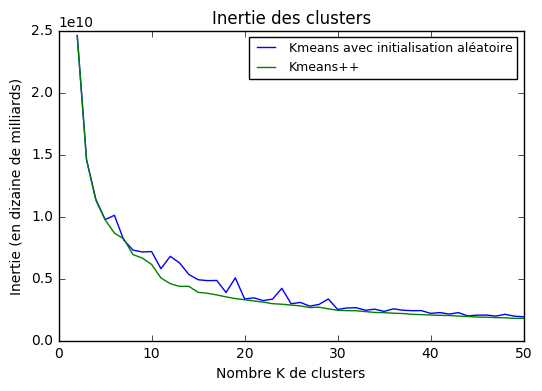

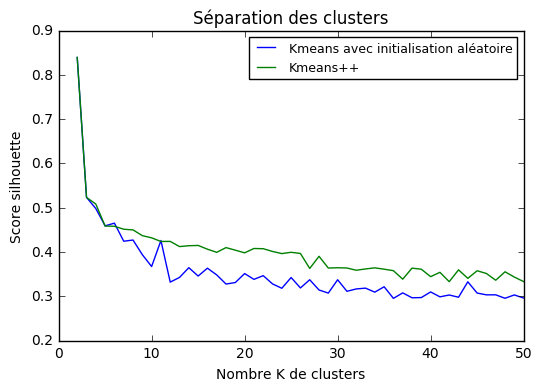

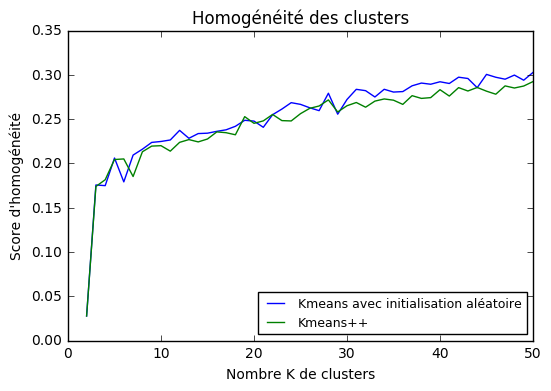

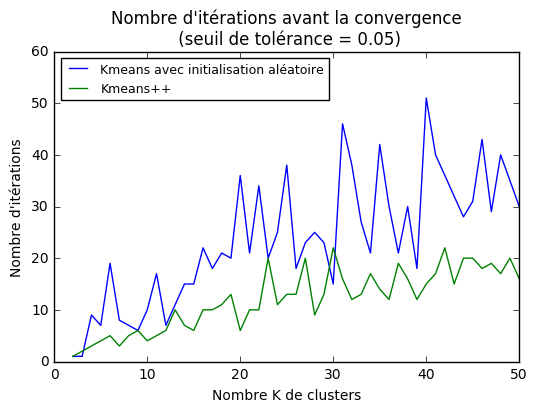

In [12]:
# Inertie
fig = plt.figure(1)
ax = fig.add_subplot(111)

ax.plot(K, inertie_rand, 'b-', label = "Kmeans avec initialisation aléatoire")
ax.plot(K, inertie_plus, 'g-', label = "Kmeans++")

ax.set_xlabel('Nombre K de clusters')
ax.set_ylabel("Inertie (en dizaine de milliards)")

plt.title("Inertie des clusters")
plt.legend(prop={'size':9})



# Score silhouette
fig = plt.figure(2)
ax = fig.add_subplot(111)

ax.plot(K, silhouette_rand, 'b-', label = "Kmeans avec initialisation aléatoire")
ax.plot(K, silhouette_plus, 'g-', label = "Kmeans++")

ax.set_xlabel('Nombre K de clusters')
ax.set_ylabel("Score silhouette")

plt.title("Séparation des clusters")
plt.legend(prop={'size':9})


# Score d'homogénéité
fig = plt.figure(3)
ax = fig.add_subplot(111)

ax.plot(K, homogeneity_rand, 'b-', label = "Kmeans avec initialisation aléatoire")
ax.plot(K, homogeneity_plus, 'g-', label = "Kmeans++")

ax.set_xlabel('Nombre K de clusters')
ax.set_ylabel("Score d'homogénéité")

plt.title("Homogénéité des clusters")
plt.legend(loc='lower right', prop={'size':9})


# Nombre d'itérations
fig = plt.figure(4)
ax = fig.add_subplot(111)

ax.plot(K, init_rand, 'b-', label = "Kmeans avec initialisation aléatoire")
ax.plot(K, init_plus, 'g-', label = "Kmeans++")

ax.set_xlabel('Nombre K de clusters')
ax.set_ylabel("Nombre d'itérations")

plt.title("Nombre d'itérations avant la convergence\n (seuil de tolérance = 0.05)")
plt.legend(loc = 'upper left', prop={'size':9})

plt.show()

In [13]:
from sklearn.externals import joblib
joblib.dump(K, "K")
joblib.dump(silhouette_plus, "silhouette_plus")
joblib.dump(homogeneity_plus,"homogeneity_plus")
joblib.dump(init_plus, "init_plus")
joblib.dump(init_rand, "init_rand")
joblib.dump(silhouette_rand, "silhouette_rand")
joblib.dump(homogeneity_rand, "homogeneity_rand")
joblib.dump(inertie_rand, "inertie_rand")
joblib.dump(inertie_plus, "inertie_plus")

['inertie_plus']

In [86]:
# Score d'homogénéité obtenue sur la base test
kmeans_plus_test = KMeans(n_clusters = 4, init= "k-means++", n_init = 1, tol=0.05)
kmeans_plus_test.fit(X_train)
h_plus_test = homogeneity_score(y_test, kmeans_plus_test.predict(X_test))
s_plus_test = silhouette_score(X_test, kmeans_plus_test.predict(X_test))
print("Score d'homogénéité:" ,h_plus_test)
print("Score silhouette:", s_plus_test)

Score d'homogénéité: 0.196810926149
Score silhouette: 0.439008288755


In [88]:
# Score d'homogénéité obtenue sur la base test
kmeans_rand_test = KMeans(n_clusters = 4, init= "random", n_init = 1, tol=0.05)
kmeans_rand_test.fit(X_train)
h_rand_test = homogeneity_score(y_test, kmeans_rand_test.predict(X_test))
s_rand_test = silhouette_score(X_test, kmeans_rand_test.predict(X_test))
print("Score d'homogénéité:",h_rand_test)
print("Score silhouette:", s_rand_test)

Score d'homogénéité: 0.203673225241
Score silhouette: 0.484414743416


###  III - 2.  Distribué

#### Définitions des différentes fonctions utilisées 


In [14]:
def dist_eucl(C,p,p_minkowski=3) : 
    return (np.sum((C - p) ** 2) )

def dist_man(C,p,p_minkowski=3) : 
    return (np.sum(abs(C - p)))

def dist_min(C,p,p_minkowski=3) : 
    return ((np.sum(abs(C - p) ** p_minkowski))**(1/p_minkowski) )

In [15]:
def init_kmeans_plus(K, rdd,distance="distance_euclidienne",p_minkowski=3):
    if distance=="distance_euclidienne":
        dist = dist_eucl
    elif distance=="distance_manhattan":
        dist = dist_man
    elif distance=="distance_minkowski":
        dist = dist_min
    else :
        print("La distance n'est pas reconnue")
        sys.exit()
        
    C = rdd.takeSample(False, 1, 1)
    init = [C]
    for i in range(1, K): 
        poids = rdd.map(lambda p : dist(C,p,p_minkowski))
        C = rdd.collect()[np.argmax(poids)]
        init += [C]
    return(init)
# init_kmeans_plus est la liste des K centres initiaux

In [16]:
def Plus_Proche_Centre_Point(p,K_centres,distance="distance_euclidienne",p_minkowski=3):

    if distance=="distance_euclidienne":
        dist = dist_eucl
    elif distance=="distance_manhattan":
        dist = dist_man
    elif distance=="distance_minkowski":
        dist = dist_min
    else :
        print("La distance n'est pas reconnue")
        sys.exit()
        
    Indice_Distance_min = 0
    Distance_min = dist(p,K_centres[0],p_minkowski)
    Deuxieme_Indice_Distance_min = 1
    Deuxieme_Distance_min = dist(p,K_centres[1],p_minkowski)

        
    for j in range(1,len(K_centres)):
        Distance_centre = dist(p,K_centres[j],p_minkowski)
        if Distance_centre < Distance_min:
            Deuxieme_Indice_Distance_min = Indice_Distance_min
            Deuxieme_Distance_min = Distance_min
            Distance_min = Distance_centre
            Indice_Distance_min = j
        elif Distance_centre < Deuxieme_Distance_min:
            Deuxieme_Indice_Distance_min = j
            Deuxieme_Distance_min = Distance_centre
            
    return (Indice_Distance_min, Distance_min, Deuxieme_Indice_Distance_min, Deuxieme_Distance_min)

In [17]:
def K_Means_distribue(data,K=2,distance="distance_euclidienne",p_minkowski=3,Distance_max=float(0.05),meth_initialisation="random",labels=None):

    ########## ETAPE 1 - CHOIX DES PARAMETRES DE L'ALGORITHME
    # K :            Nombre de plus proches voisins à considérer (entier strictement supérieur à 1)
    # Distance_max : Distance maximale lors de la dernière exécution entre les centres des 
    #                clusters à l'étape n-1 et ceux à l'étape n (dernière exécution)
    # distance :     Mesure utilisée pour calculer la distance entre deux points
    if distance=="distance_euclidienne":
        dist = dist_eucl
    elif distance=="distance_manhattan":
        dist = dist_man
    elif distance=="distance_minkowski":
        dist = dist_min
    else :
        print("La distance n'est pas reconnue")
        sys.exit()
    ########## ETAPE 2 - INITIALISATION DES CENTRES DES K CLUSTERS
    # "random" :   On choisit K éléments de la base 
    #              L'ajout du paramètre False comme premier argument permet à l'échantillon choisit d'etre 2 à 2 distincts
    # "Kmeans++" : A DECRIRE
    #              A DECRIRE
    if meth_initialisation=="random" :
        K_Centres = data.takeSample(False, K, 34)
    elif meth_initialisation=="Kmeans++" :     
        K_Centres = init_kmeans_plus(K, data,distance,p_minkowski)
    else: 
        print("La méthode d'initialisarion des centres des clusters n'est pas reconnue")
        sys.exit()
    
    Centres_Initiaux = K_Centres
    #print("Les centres initiaux des K clusters sont : ",K_Centres)

    ########## ETAPE 3 : INITIALISATION DES PARAMETRES PERMETTANT D'EXECUTER UNE PREMIERE FOIS LA BOUCLE ITERATIVE DE L'ALGO
    # i :               Nombre d'itérations de la boucle
    # Distance_centre : Initialisation de la distance entre les centres des clusters à l'étape i et 
    #                   ceux à l'étape i+1 de manière arbitraire on prend n'importe quel
    #                   réel strictement supérieur à Distance_max
    i = 0
    Distance_centre = 10


    ##### ETAPE 4 : PARTIE ITERATIVE DE L'ALGORITHME
    # Répéter jusqu'à ce qu'il y ait convergence :
    while Distance_centre > Distance_max:
    
        # Mise à jour du nombre d'itérations effectuées
        i=i+1
    
        # Assigner à chaque observation de la base:
        # - le centre des clusters qui lui est le plus proche, la distance associé
        # - le deuxième centre des clusters qui lui est le plus proche, la distance associé
        # - le point lui même
        # - un '1' qui nous permettra de compter le nombre de point associé à chaque cluster
        Plus_Proche_Centre = data.map(
            lambda p: (Plus_Proche_Centre_Point(p, K_Centres,distance,p_minkowski), (p, 1)))
        
        # Création du nouveau centre de chaque cluster
        Plus_Proche_Centre = data.map(
            lambda p: array([Plus_Proche_Centre_Point(p, K_Centres,distance,p_minkowski), (p, 1)]))
        
        Plus_Proche_Centre_red =  Plus_Proche_Centre.map(
                         lambda p : (p[0][0],p[1]))
        
        K_Nouveaux_Centres = Plus_Proche_Centre_red.reduceByKey(
            lambda p1, p2: (p1[0] + p2[0], p1[1] + p2[1])).map(
                lambda p: (p[0], p[1][0] / p[1][1])).collect()
        
        # Mise à jour de la distance entre les centres des clusters à l'étape i et ceux à l'étape i+1
        Distance_centre = sum(np.sum((K_Centres[j] - p) ** 2) for (j, p) in K_Nouveaux_Centres)

        # Mise à jour du centre de chaque cluster
        for (j, p) in K_Nouveaux_Centres:
            K_Centres[j] = p

            
    # Calcul des différents scores
       
    ## Meth 1 : Inertie
    score = Plus_Proche_Centre.map(
                lambda p: p[0][1])
    inertie = sum(score.collect())
      
    ## Meth2 : silhouette
    a=  Plus_Proche_Centre.map(
                lambda p: (p[0][0],  (p[0][1],1 ) ))
    
    mean_dist_clust = a.reduceByKey(
                        lambda p1, p2: (p1[0] + p2[0], p1[1] + p2[1])).map(
                        lambda p: (p[0], p[1][0] / p[1][1])).collect()
    silhouette = Plus_Proche_Centre.map(
                lambda p: (p[0][3]-mean_dist_clust[p[0][0]][1])/max(p[0][3],mean_dist_clust[p[0][0]][1]))
    silhouette = np.mean(silhouette.collect())
    
    ## Meth3 : Homogéneité : Uniquement si Labels !=None
    if labels !=None:
            labels_true = np.array(labels.map(lambda x : x[0]).collect())
            cluster_pred = np.array(Plus_Proche_Centre.map(
                            lambda p: p[0][0]).collect())
            homogeneite = homogeneity_score(labels_true, cluster_pred)
    
    
    # On retourne 
    # i : le nombre d'itérations nécessaires à l'algo pour converger
    # K_Centres : les centres finaux des K clusters 
    # Plus_Proche_Centre : l'assignation de chaque point à son cluster
    mon_dictionnaire = {}
    mon_dictionnaire["nb_itérations"] = i
    mon_dictionnaire["centres initiaux"] = Centres_Initiaux 
    mon_dictionnaire["K_centroïdes_finaux"] = K_Centres
    mon_dictionnaire["Plus_Proches_Centre"] = Plus_Proche_Centre
    mon_dictionnaire["Inertie"] = inertie
    mon_dictionnaire["Silhouette"] = silhouette
    if labels !=None:
        mon_dictionnaire["Homogénéité"] = homogeneite

    return(mon_dictionnaire)



### Performances de l'algorithme

In [58]:
dK = []
dsilhouette_plus = []
dhomogeneity_plus = []
dinit_plus = []
dinit_rand = []
dsilhouette_rand =[]
dhomogeneity_rand = []
dinertie_rand = []
dinertie_plus = []

for k in range(2,51): 
    dK += [k]
    dkmeans_rand = K_Means_distribue(dico_base['data_app'],k,"distance_euclidienne",3,float(0.05),"random",dico_base['labels_app'])
    dkmeans_plus = K_Means_distribue(dico_base['data_app'],k,"distance_euclidienne",3,float(0.05),"Kmeans++",dico_base['labels_app'])
    din_rand = dkmeans_rand['Inertie']
    din_plus = dkmeans_plus['Inertie']
    ds_plus = dkmeans_plus['Silhouette']
    dh_plus = dkmeans_plus['Homogénéité'] 
    ds_rand = dkmeans_rand['Silhouette']
    dh_rand = dkmeans_rand['Homogénéité'] 
    di_plus = dkmeans_plus['nb_itérations']
    di_rand = dkmeans_rand['nb_itérations']
    print("------------------------------------------------")
    print("For K=%s :" %k)
    print("")
    print("Init : random")
    print("Silhouette score :", ds_rand)
    print("Homogeneity score :", dh_rand)
    print("Nb of iterations :", di_rand)
    print("Inertie : ", din_rand)
    print("")
    print("Init : kmeans++")
    print("Silhouette score :", ds_plus)
    print("Homogeneity score :", dh_plus)
    print("Nb of iterations :", di_plus)
    print("Inertie :", din_plus)
    print("------------------------------------------------")
    dsilhouette_plus += [ds_plus]
    dhomogeneity_plus += [dh_plus]
    dinit_plus += [di_plus]
    dinit_rand += [di_rand]
    dsilhouette_rand +=[ds_rand]
    dhomogeneity_rand +=[dh_rand]
    dinertie_rand += [din_rand]
    dinertie_plus += [din_plus]
    
joblib.dump(dK, "dK")
joblib.dump(dsilhouette_plus, "dsilhouette_plus")
joblib.dump(dhomogeneity_plus,"dhomogeneity_plus")
joblib.dump(dinit_plus, "dinit_plus")
joblib.dump(dinit_rand, "dinit_rand")
joblib.dump(dsilhouette_rand, "dsilhouette_rand")
joblib.dump(dhomogeneity_rand, "dhomogeneity_rand")
joblib.dump(dinertie_rand, "dinertie_rand")
joblib.dump(dinertie_plus, "dinertie_plus")

------------------------------------------------
For K=2 :

Init : random
Silhouette score : 0.979186206489
Homogeneity score : 0.0276774374619
Nb of iterations : 2
Inertie :  24597747335.3

Init : kmeans++
Silhouette score : 0.979186206489
Homogeneity score : 0.0276774374619
Nb of iterations : 4
Inertie : 24597747335.3
------------------------------------------------
------------------------------------------------
For K=3 :

Init : random
Silhouette score : 0.72096454777
Homogeneity score : 0.177903652528
Nb of iterations : 12
Inertie :  14582763342.8

Init : kmeans++
Silhouette score : 0.817648362041
Homogeneity score : 0.178083643561
Nb of iterations : 13
Inertie : 14582763682.1
------------------------------------------------
------------------------------------------------
For K=4 :

Init : random
Silhouette score : 0.671439670758
Homogeneity score : 0.180682960313
Nb of iterations : 22
Inertie :  11294894197.1

Init : kmeans++
Silhouette score : 0.757649116061
Homogeneity score 

['dinertie_plus']

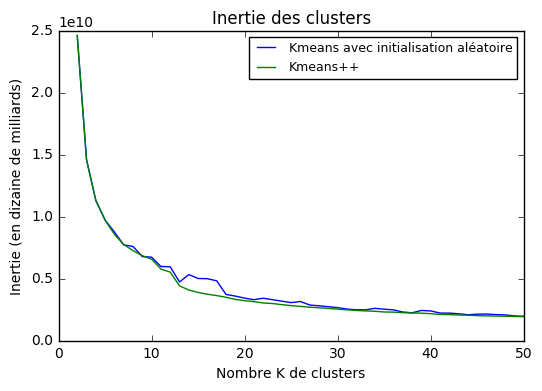

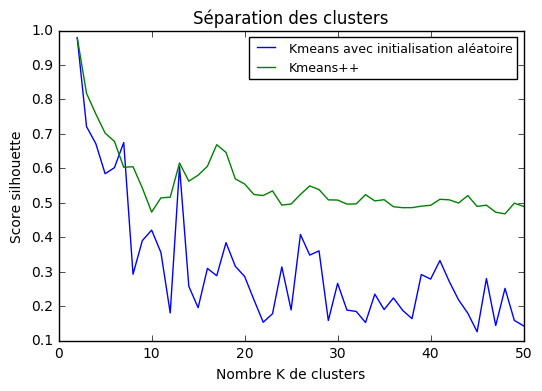

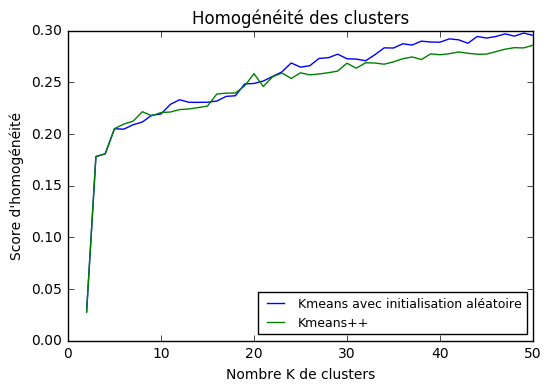

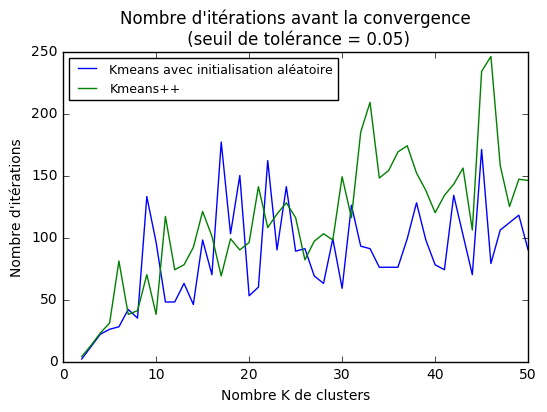

In [60]:
# Inertie
dfig = plt.figure(1)
ax2 = dfig.add_subplot(111)

ax2.plot(dK, dinertie_rand, 'b-', label = "Kmeans avec initialisation aléatoire")
ax2.plot(dK, dinertie_plus, 'g-', label = "Kmeans++")

ax2.set_xlabel('Nombre K de clusters')
ax2.set_ylabel("Inertie (en dizaine de milliards)")

plt.title("Inertie des clusters")
plt.legend(prop={'size':9})


# Score silhouette
dfig = plt.figure(2)
ax2 = dfig.add_subplot(111)

ax2.plot(dK, dsilhouette_rand, 'b-', label = "Kmeans avec initialisation aléatoire")
ax2.plot(dK, dsilhouette_plus, 'g-', label = "Kmeans++")

ax2.set_xlabel('Nombre K de clusters')
ax2.set_ylabel("Score silhouette")

plt.title("Séparation des clusters")
plt.legend(prop={'size':9})


# Score d'homogénéité
dfig = plt.figure(3)
ax2 = dfig.add_subplot(111)

ax2.plot(dK, dhomogeneity_rand, 'b-', label = "Kmeans avec initialisation aléatoire")
ax2.plot(dK, dhomogeneity_plus, 'g-', label = "Kmeans++")

ax2.set_xlabel('Nombre K de clusters')
ax2.set_ylabel("Score d'homogénéité")

plt.title("Homogénéité des clusters")
plt.legend(loc='lower right', prop={'size':9})


# Nombre d'itérations
dfig = plt.figure(4)
ax2 = dfig.add_subplot(111)

ax2.plot(dK, dinit_rand, 'b-', label = "Kmeans avec initialisation aléatoire")
ax2.plot(dK, dinit_plus, 'g-', label = "Kmeans++")

ax2.set_xlabel('Nombre K de clusters')
ax2.set_ylabel("Nombre d'itérations")

plt.title("Nombre d'itérations avant la convergence\n (seuil de tolérance = 0.05)")
plt.legend(loc = 'upper left', prop={'size':9})

plt.show()

### Comparaison des deux algorithmes

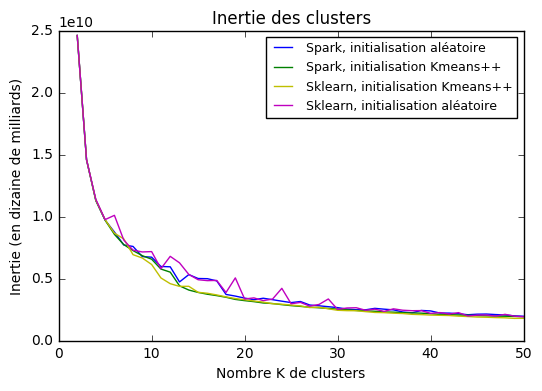

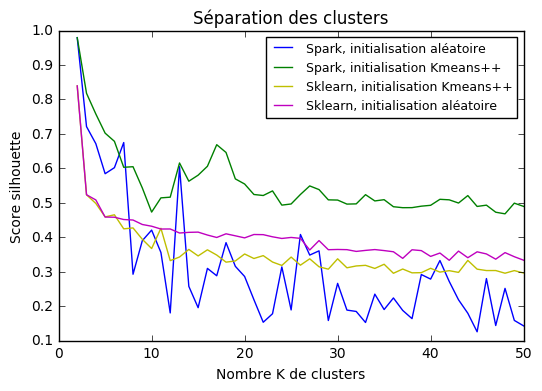

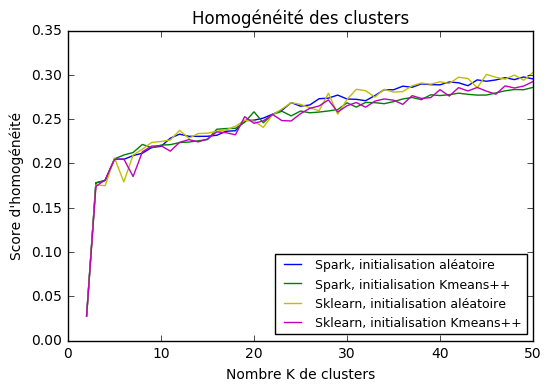

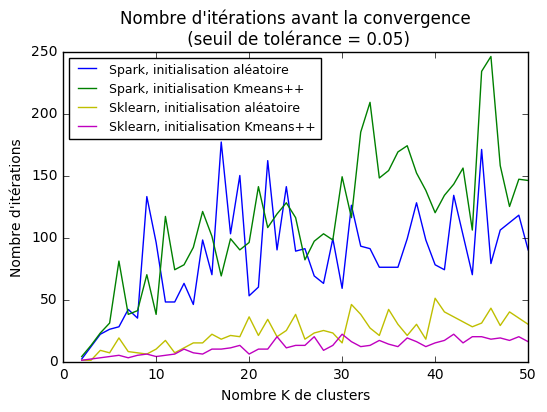

In [68]:

# Inertie
dfig = plt.figure(1)
ax2 = dfig.add_subplot(111)

ax2.plot(dK, dinertie_rand, 'b-', label = "Spark, initialisation aléatoire")
ax2.plot(dK, dinertie_plus, 'g-', label = "Spark, initialisation Kmeans++")
ax2.plot(dK, inertie_plus, 'y-', label = "Sklearn, initialisation Kmeans++")
ax2.plot(dK, inertie_rand, 'm-', label = "Sklearn, initialisation aléatoire")

ax2.set_xlabel('Nombre K de clusters')
ax2.set_ylabel("Inertie (en dizaine de milliards)")

plt.title("Inertie des clusters")
plt.legend(prop={'size':9})


# Score silhouette
dfig = plt.figure(2)
ax2 = dfig.add_subplot(111)

ax2.plot(dK, dsilhouette_rand, 'b-', label = "Spark, initialisation aléatoire")
ax2.plot(dK, dsilhouette_plus, 'g-', label = "Spark, initialisation Kmeans++")
ax2.plot(dK, silhouette_rand, 'y-', label = "Sklearn, initialisation Kmeans++")
ax2.plot(dK, silhouette_plus, 'm-', label = "Sklearn, initialisation aléatoire")


ax2.set_xlabel('Nombre K de clusters')
ax2.set_ylabel("Score silhouette")

plt.title("Séparation des clusters")
plt.legend(prop={'size':9})


# Score d'homogénéité
dfig = plt.figure(3)
ax2 = dfig.add_subplot(111)

ax2.plot(dK, dhomogeneity_rand, 'b-', label = "Spark, initialisation aléatoire")
ax2.plot(dK, dhomogeneity_plus, 'g-', label = "Spark, initialisation Kmeans++")
ax2.plot(dK, homogeneity_rand, 'y-', label = "Sklearn, initialisation aléatoire")
ax2.plot(dK, homogeneity_plus, 'm-', label = "Sklearn, initialisation Kmeans++")


ax2.set_xlabel('Nombre K de clusters')
ax2.set_ylabel("Score d'homogénéité")

plt.title("Homogénéité des clusters")
plt.legend(loc='lower right', prop={'size':9})


# Nombre d'itérations
dfig = plt.figure(4)
ax2 = dfig.add_subplot(111)

ax2.plot(dK, dinit_rand, 'b-', label = "Spark, initialisation aléatoire")
ax2.plot(dK, dinit_plus, 'g-', label =  "Spark, initialisation Kmeans++")
ax2.plot(dK, init_rand, 'y-', label = "Sklearn, initialisation aléatoire")
ax2.plot(dK, init_plus, 'm-', label = "Sklearn, initialisation Kmeans++")


ax2.set_xlabel('Nombre K de clusters')
ax2.set_ylabel("Nombre d'itérations")

plt.title("Nombre d'itérations avant la convergence\n (seuil de tolérance = 0.05)")
plt.legend(loc = 'upper left', prop={'size':9})

plt.show()

In [69]:
test = K_Means_distribue(dico_base['data_test'],4,"distance_euclidienne",3,float(0.05),"random",dico_base['labels_test'])
test

{'Homogénéité': 0.19147078940504531,
 'Inertie': 1145972537.4768832,
 'K_centroïdes_finaux': [array([  3.93780718e+01,   2.86267447e+00,   1.77179723e+00,
           1.22600673e+01,   8.83157072e+00,   1.41221153e-02,
           8.77715501e-03,   1.06411764e-01,   5.98509943e-02,
           3.40159927e+03,   1.24149942e+03,   6.82546458e+03,
           2.44737621e+03,   8.24617622e+02,   9.40472968e+02,
           1.09839958e+02,   5.31663997e+01,   5.07337464e-01,
           4.84696053e-01]),
  array([  2.22930657e+02,   2.38603903e+00,   1.29401923e+00,
           7.62134091e+00,   4.22022685e+00,   1.64823704e-02,
           1.23618796e-02,   1.09294942e-01,   5.81390328e-02,
           3.80302249e+03,   6.76701679e+02,   7.49861715e+03,
           1.28083235e+03,   1.37680583e+03,   2.01094451e+03,
           1.24378432e+02,   4.30320063e+01,   5.14355534e-01,
           5.04212183e-01]),
  array([  4.44197952e+01,   3.04697380e+00,   1.62403015e+00,
           1.21723718e+01,   7.

In [70]:
test2 = K_Means_distribue(dico_base['data_test'],4,"distance_euclidienne",3,float(0.05),"Kmeans++",dico_base['labels_test'])
test2

{'Homogénéité': 0.19147078940504531,
 'Inertie': 1145972537.4768832,
 'K_centroïdes_finaux': [array([ 154.35074627,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.52519412,    0.49860223]),
  array([  2.22930657e+02,   2.38603903e+00,   1.29401923e+00,
           7.62134091e+00,   4.22022685e+00,   1.64823704e-02,
           1.23618796e-02,   1.09294942e-01,   5.81390328e-02,
           3.80302249e+03,   6.76701679e+02,   7.49861715e+03,
           1.28083235e+03,   1.37680583e+03,   2.01094451e+03,
           1.24378432e+02,   4.30320063e+01,   5.14355534e-01,
           5.04212183e-01]),
  array([  3.93780718e+01,   2.86267447e+00,   1.77179723e+00,
           1.22600673e+01,   8.83157072e+00,   1.41221153e-02,
           8.77715501e-03,   1.06411764e-01

In [81]:
def Score_Test(data_test,K_clusters_finaux,distance="distance_euclidienne",p_minkowski=3,labels_test=None):
    
    Plus_Proche_Centre = data_test.map(
            lambda p: array([Plus_Proche_Centre_Point(p, K_clusters_finaux,distance,p_minkowski), (p, 1)]))
    # Calcul des différents scores
       
    ## Meth 1 : Inertie
    score = Plus_Proche_Centre.map(
                lambda p: p[0][1])
    inertie = sum(score.collect())
      
    ## Meth2 : silhouette
    a=  Plus_Proche_Centre.map(
                lambda p: (p[0][0],  (p[0][1],1 ) ))
    
    mean_dist_clust = a.reduceByKey(
                        lambda p1, p2: (p1[0] + p2[0], p1[1] + p2[1])).map(
                        lambda p: (p[0], p[1][0] / p[1][1])).collect()
    silhouette = Plus_Proche_Centre.map(
                lambda p: (p[0][3]-mean_dist_clust[p[0][0]][1])/max(p[0][3],mean_dist_clust[p[0][0]][1]))
    silhouette = np.mean(silhouette.collect())
    
    ## Meth3 : Homogéneité : Uniquement si labels_test !=None
    if labels_test !=None:
            labels_true = np.array(labels_test.map(lambda x : x[0]).collect())
            cluster_pred = np.array(Plus_Proche_Centre.map(
                            lambda p: p[0][0]).collect())
            homogeneite = homogeneity_score(labels_true, cluster_pred)
    
    
    # On retourne 
    mon_dictionnaire = {}
    mon_dictionnaire["Inertie"] = inertie
    mon_dictionnaire["Silhouette"] = silhouette
    if labels_test !=None:
        mon_dictionnaire["Homogénéité"] = homogeneite

    return(mon_dictionnaire)

In [83]:
liste_distance=["distance_euclidienne","distance_manhattan","distance_minkowski"]
liste_meth_init=["random","Kmeans++"]
p_minkowski=3

for dist in  liste_distance:
    for meth in liste_meth_init:
        dico = K_Means_distribue(dico_base['data_app'],4,dist,p_minkowski,float(0.05),meth,dico_base['labels_app'])
        K_clusters_finaux = dico['K_centroïdes_finaux']
        print("-----------------------------------------------------------------------")
        print("distance :",dist)
        print("méthode d'initialisation :",meth)
        print(Score_Test(dico_base['data_test'],K_clusters_finaux,dist,p_minkowski,dico_base['labels_test']))


-----------------------------------------------------------------------
distance : distance_euclidienne
méthode d'initialisation : random
{'Silhouette': 0.70125981042248331, 'Homogénéité': 0.19145089851715966, 'Inertie': 1148161992.0409}
-----------------------------------------------------------------------
distance : distance_euclidienne
méthode d'initialisation : Kmeans++
{'Silhouette': 0.7916537137365518, 'Homogénéité': 0.19145089851715966, 'Inertie': 1148161992.0409}
-----------------------------------------------------------------------
distance : distance_manhattan
méthode d'initialisation : random
{'Silhouette': 0.57590656610284463, 'Homogénéité': 0.17653717890197268, 'Inertie': 2340450.3565307576}
-----------------------------------------------------------------------
distance : distance_manhattan
méthode d'initialisation : Kmeans++
{'Silhouette': 0.52632467548815842, 'Homogénéité': 0.15428010203153217, 'Inertie': 2306513.0188528937}
-------------------------------------------

In [85]:
Score_Test(dico_base['data_test'],K_clusters_finaux,dist,p_minkowski,dico_base['labels_test'])

{'Homogénéité': 0.19993594597114048,
 'Inertie': 995824.39238750201,
 'Silhouette': 0.56733481214567338}